## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**project_id** | A unique identifier for the proposed project | **Example:** `p036502`|  
--------------|---------------------------------------------------|--------------------|
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [229]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [125]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [126]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
project_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [127]:
print("Number of data points in resource data", resource_data.shape)
resource_data.head(2)

Number of data points in resource data (1541272, 4)


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


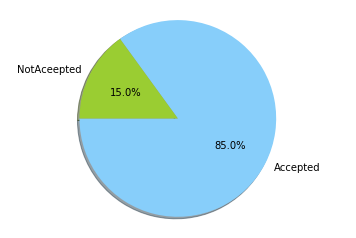

In [128]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.ht #sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

import matplotlib.pyplot as plt

#https://pythonspot.com/matplotlib-pie-chart/
# Data to plot
labels = 'Accepted','NotAceepted'
sizes = [34, 6]
colors = ['lightskyblue', 'yellowgreen']
explode = (0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)

plt.axis('equal')
plt.show()

# Summery
**1. Total no of  project proposal recieved for funding is 109248 out of recieved proposal only 92706 are approved for funding and 16542 not approved for funding**

**2. approximatly 85 % project are aproved and approximate %15 of project are  rejected for funding**


### 1.2.1 Univariate Analysis: School State

In [129]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [130]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))

print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


# Summery:
**1. Delaware (DE) state from the United States has the highest percent of projects acceptence rate almost 90% then, followed by North Dakota (ND) and Washington (WA) nearly 89% and 88% respectively each.**

 **2. Vermont (VT) has the lowest Approval rate with exactly 80% followed by Columbia (DC) and Texas (TX) with nearly 80% and 81% respectively.**

In [131]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
import numpy as np
import matplotlib.pyplot as plt
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [132]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

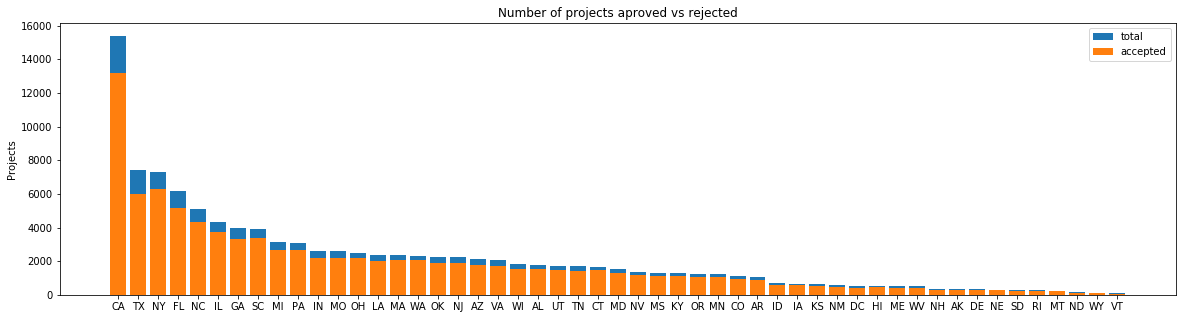

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [133]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

# summery
**1.Every state has greater than 80% success rate in approval**<br>

**2.California propose 13205 projects for funding out of that project's almost 13205 project's are approved. that is aproximatly 86% of project's are approved for funding.<br>**

**3.texas and New York Apply almost same no of project for approval but New York aprroval rate is almost 86% and texas aproval rate almost 82% <br>**

**4.North Dakota having highest approval rate almost 89%. in North Dakota 243 project approved out of 285 project's<br>**

**5.the state code having CA,TX,NY,FL,NC are proposed maximum no of projects for approval and all the state having aprroval< rate of project are almost in between 82% to 85%.<br>**

**6.similarly state code having RI,MI,ND,WY,VT are low rate Proposing the project's till approval rate is higher in between  80% to 89% percent project are approved for funding for this state.<br>**

### 1.2.2 Univariate Analysis: teacher_prefix

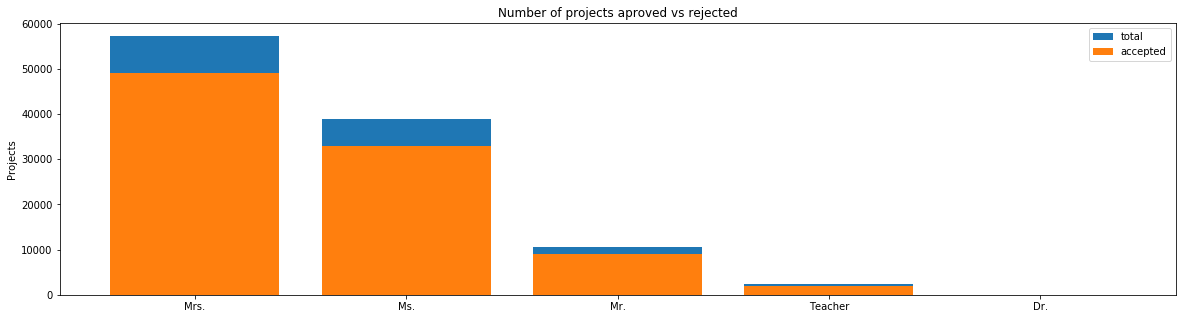

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [134]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

# Summery: 
**1.Teachers with prefixes Mrs are highest number of project's approval almost 86%**<br>

**2.Teacher with perfixes MS and Mr having almost same no of project approval that is 85%**<br>

**3.Teachers with Dr. title have proposed hardly 13 projects and out of which 9 of them have been approved.**<br>

### 1.2.3 Univariate Analysis: project_grade_category

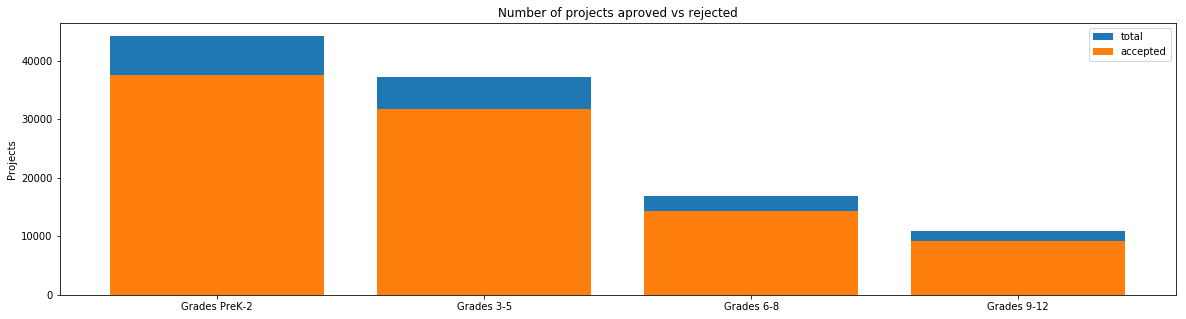

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [135]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)


# Summery
**1. There are alot of projects proposed for the students between Pre Kindergarden and 2nd Grade while for the rest it keeps decreasing.**

**2. The average Acceptance rate of the project is 84% irrespective of the Grade.**

**3. We also notice that Students between the 9th Grade and 12th Grade have the lowest number of projects proposed as well as accepted approximatly 84%.**

### 1.2.4 Univariate Analysis: project_subject_categories

In [136]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
removetable = str.maketrans('', '', '@#%')
out_list = [s.translate(removetable) for s in catogories]
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'))
    
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into _
    cat_list.append(temp.strip())

In [137]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

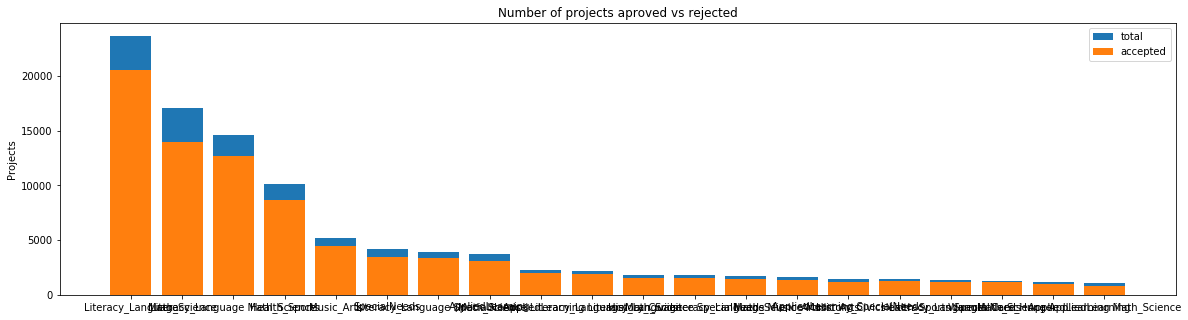

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [138]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

# Summery
**1. Projects belonging to the Literacy and Language categories have the highest number of projects proposal's and acceptance rate of this projects's nearly 87%.**

 **2. Projects belonging to both Maths and Science have acceptance rate of nearly 82% while introducing the concept of Literacy and Language to this can increase its accpetance rate to nearly 87%**

 **3. There is a lot of variablity in the total number of projects proposed per Category of the project.**

**4. Projects belonging to both Maths and Science when combined with Applied Learning has the least number of projects proposed as well approving rate.**

 **5. Warmth, Care and Hunger have an acceptance rate almost 93% that means acceptane rate this categories is higher then other categories**

In [139]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

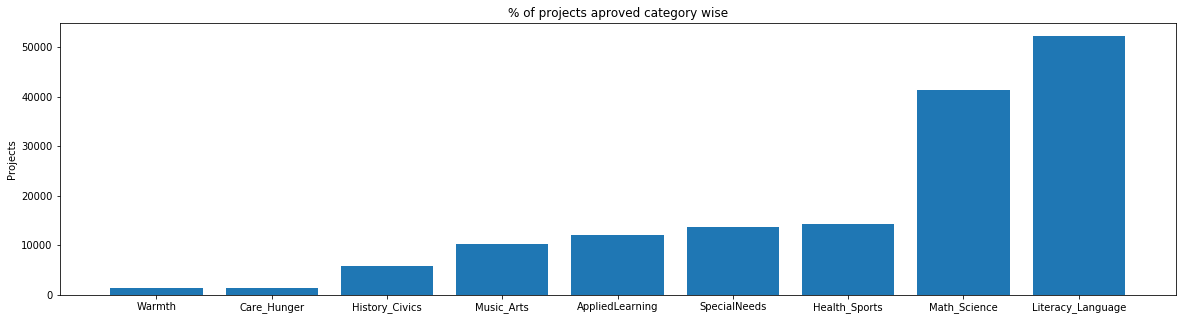

In [140]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [141]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


# Summery
**1.literacy language have maximum no of project's approval 52239, followed by math_science 41421**

**2.warmth,care and hunger have lowest rate of project approval 1388 **

**3.music_arts,Apliedlearning ,special_needs and health_sports project approved rate in the range between 11000 to 150000. **


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [142]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [143]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

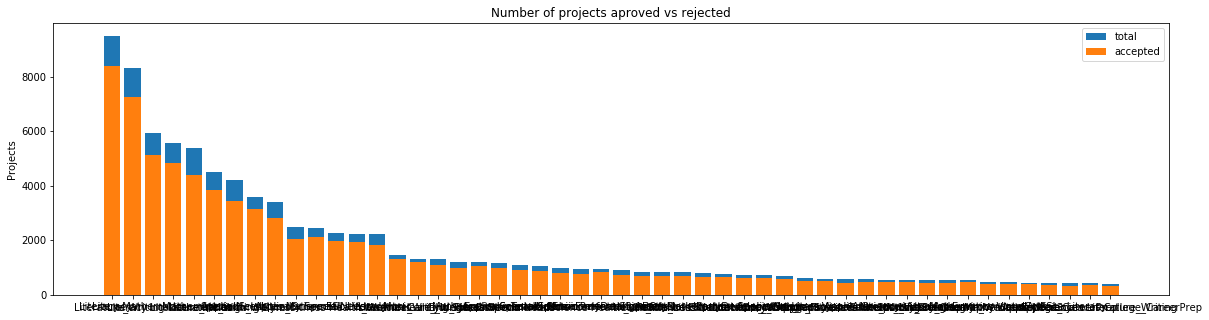

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [144]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

## Summery:
### Project aproved VS Rejected
**1.Almost all subject approval rate is above 80 %**

**2.Literacy having a highest number of project approved almost 89%. that means 9486 project are proposed out of that project's almost 8371 project are approved. followed by Literacy Mathematics approimatly 88% project's are approved.**
 
**3.Literature_Writing Mathematics and Literacy Literature_Writing almost same number of approval rate that is 87%**

**4.AppliedSciences College_CareerPrep has lowest proposing subject's and there approval rate also low %**





In [145]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

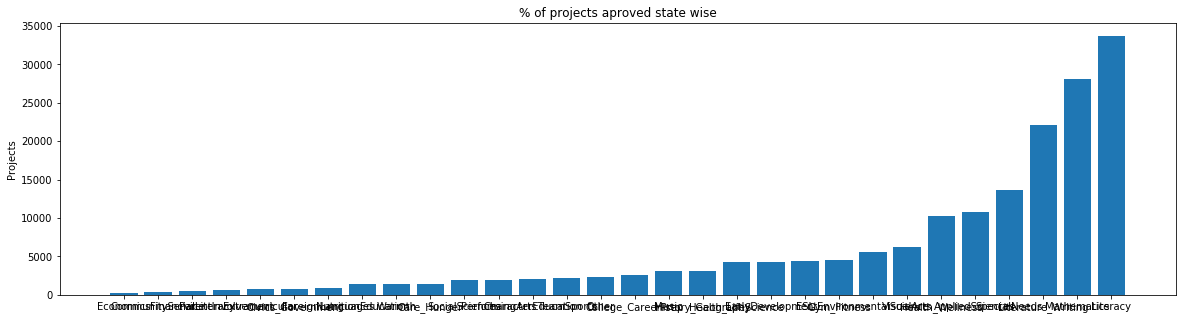

In [146]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [147]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


### 1.2.6 Univariate Analysis: Text features (Title)

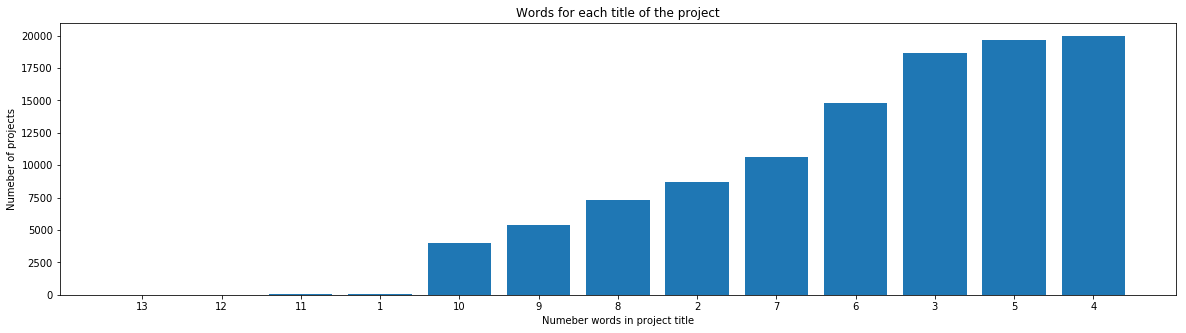

In [148]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

## Summery
### Words for each title of the project
**1.most of the projects have 4 Word's in Title**

**2.most of the projects having 3,4,5 word's in the projects**

**3.there no word's more then 10 in the project title**



In [149]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

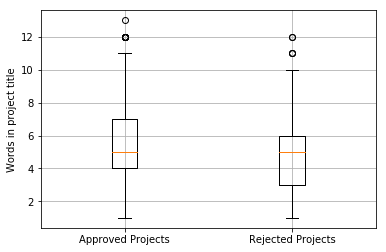

In [150]:

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

**The number of Projects approved have a slightly more number of words in the Title when we compared to the Rejected Projects**

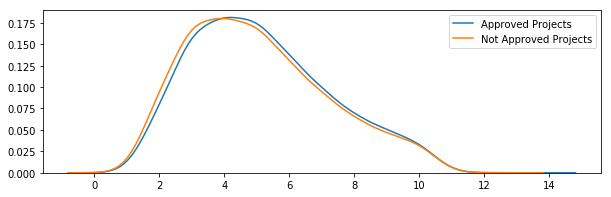

In [151]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

**can not understand  much about Approved and not approved projectsusing this plot**

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [152]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [153]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

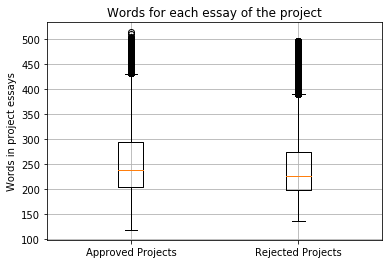

In [154]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

**1. Approved projects have a slightly more number of words in the project essays as compare to rejected.**

**2. most of the projects are rejected which eassay word's are less than 500.**

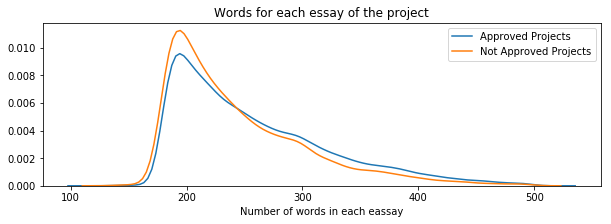

In [155]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

**The number of words in the Project Essays of Approved Projects are slightly more than the number of words in the Project Essays of the Rejected Projects. This can be noticed by looking at the Blue Line (PDF Curve of Approved Projects) which is denser for words more than 200 to almost 480 or more than 500.**

### 1.2.8 Univariate Analysis: Cost per project

In [156]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [157]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [158]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [159]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

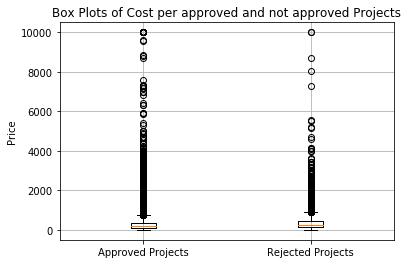

In [160]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

## Summery
**1.Rejected project cost is slighty more than Approved projects**

**2.highest number of project's is approved when it price is less 6000 doller's**

**2.most of the project is rejected if price is less 3800 doller's and price is more than 1000 doller's**

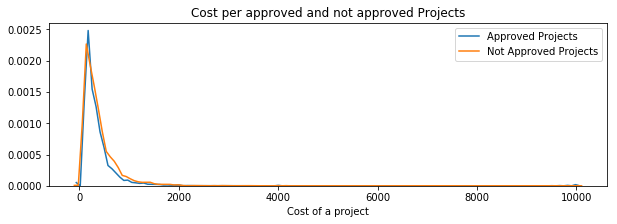

In [161]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

**Not much can be understood from the box plot depicting the Cost involved per project. We can generalise from the PDF curves that mostly Projects that are very costly are usually not approved.**

In [162]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

## summery:
**1.No of Aproved projects has less cost as compare to Not approved projects.**

**2.for 85 percentile cost of approved project is 479 doller's is very as low compare to Not approved projects 618 doller's.**

**3.Maximum no of aproval project cost is less then 10000 dollers**

<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

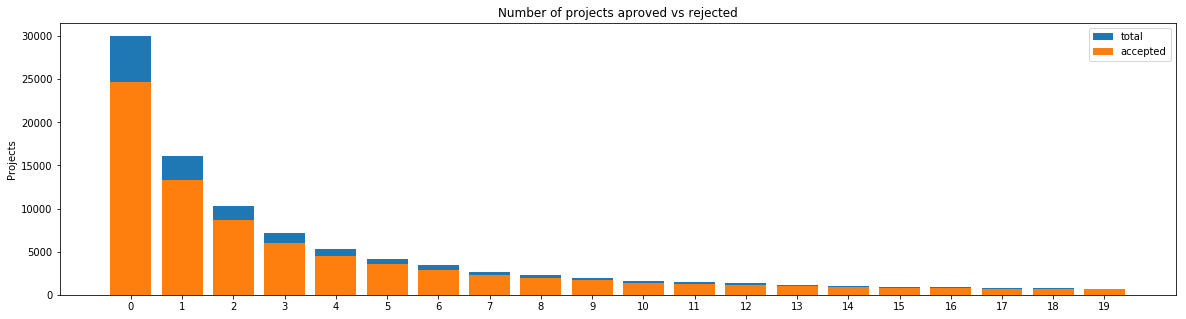

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
15                                            15                  818    942   
16                                            16                  769    894   
17                                            17                  712    803   
18                                            18                  666    772   
19                                       

In [163]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=20)

**1.teacher number of previously posted projects column show that those teacher having a 0 no of previously posted projects having maximum number of project proposal and also maximum no of projects are also aaproved.**

**2.least no of projects is approved when previously posted projects is 19 that is 710 projects are propsed and out this only 632 are finally selected.**

<h3><font color='red'>1.2.10 Univariate Analysis: project_resource_summary</font></h3>

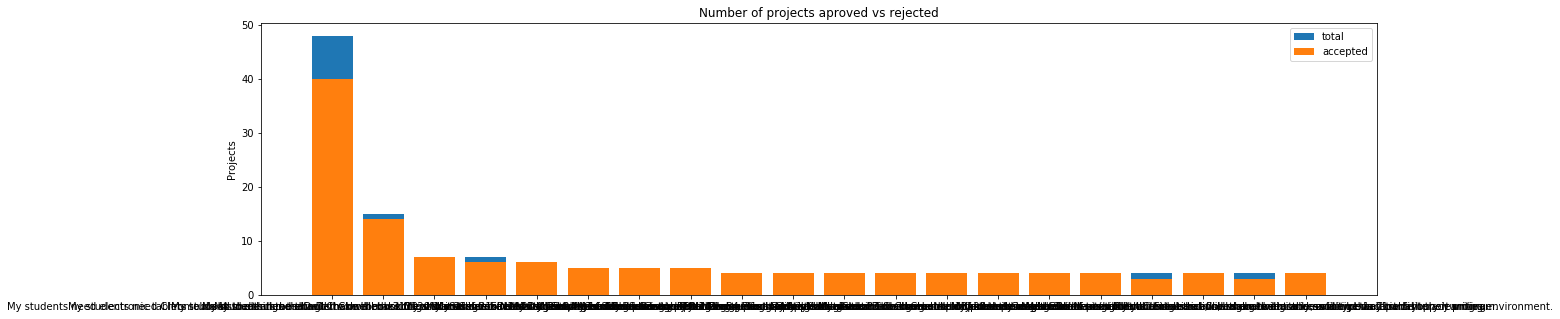

                                project_resource_summary  project_is_approved  \
56539  My students need electronic tablets to do all ...                   40   
10193  My students need Chromebooks to do all the thi...                   14   
18828  My students need a Dell Chromebook 3120 and a ...                    7   
51417  My students need chromebooks to do all the thi...                    6   
18819  My students need a Dell Chromebook 3120 11 6 C...                    6   

       total       Avg  
56539     48  0.833333  
10193     15  0.933333  
18828      7  1.000000  
51417      7  0.857143  
18819      6  1.000000  
                                project_resource_summary  project_is_approved  \
3452   My students need 3 Chromebook computers to eng...                    4   
10510  My students need Chromebooks to open the doors...                    3   
8058   My students need 8 Hokki Stools to allow them ...                    4   
91082  My students need tablets to do a

In [164]:
univariate_barplots(project_data, 'project_resource_summary', 'project_is_approved', top=20)

**1. Highest no of projects are approved when student need is electronic tablets to do all** 

**2.Those student need is diffrent types of chrombook are approval rate is less as compare to electronics tablets**

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [165]:
project_data.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  
0  My students are English learners that are work...  154.6        23  
1  Our students arrive to our school eager to lea...  299.0         1

In [166]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher inspires. -William A. Ward\r\n\r\nMy school has 803 students which is makeup is 97.6% African-American, making up the largest segment of the student body. A typical school in Dallas is made up of 23.2% African-American students. Most of the students are on free or reduced lunch. We aren't receiving doctors, lawyers, or engineers children from rich backgrounds or neighborhoods. As an educator I am inspiring minds of young children and we focus not only on academics but one smart, effective, efficient, and disciplined students with good character.In our classroom we can utilize the Bluetooth for swift transitions during class. I use a speaker which doesn't amplify the sound enough to receive the message. Due to the volume of my speaker my students can't hear videos or books clearly and it isn't making the lessons as meaningful. But with the bluetooth speaker my students will be abl

In [167]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [168]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [169]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [170]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [171]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [172]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
    

100%|██████████| 109248/109248 [02:24<00:00, 757.17it/s]


In [173]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h3><font color='red'>1.3.2 Project title Text</font></h3>

In [174]:
#printing some random eassys
print(project_data['project_title'].values[0])
print("-"*50)
print(project_data['project_title'].values[1000])
print('-'*50)
print(project_data['project_title'].values[15000])
print('-'*50)
print(project_data['project_title'].values[99999])

Educational Support for English Learners at Home
--------------------------------------------------
Sailing Into a Super 4th Grade Year
--------------------------------------------------
\r\nThe \"i\" Classroom
--------------------------------------------------
Inspiring Minds by Enhancing the Educational Experience


In [175]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [176]:
sent = decontracted(project_data['project_title'].values[60000])
print(sent)
print("="*50)

Listening Center For Learning!


In [177]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Listening Center For Learning!


In [178]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Listening Center For Learning 


In [179]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [180]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
    

100%|██████████| 109248/109248 [02:23<00:00, 763.90it/s]


In [181]:
#preprocessing project titles
preprocessed_title[40000]

'by time students enter class already know going at least believe the majority ninth graders come rural low income communities undervalue education while say hate school everyday i see engaging learning given chance my students funny clever energetic my goal teacher create atmosphere curriculum engaging in community many students much outside control entering school chance power in classroom i want feel powerful i want learn knowledge greatest power world a good classroom library least 10 choices books student walks many students identify non readers time teacher i learned no one hates reading there students not found right book my goal help find perfect book hopefully jump start love reading the books selected nominated regarded great books young adult literature these books students see relate lives with small budgets tapped resources hard provide books opportunities students need become lifelong learners this project step right direction nannan'

## 1. 4 Preparing data for models

In [182]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [183]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [184]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


In [185]:
# Please do the similar feature encoding with state, teacher_prefix and project_grade_category also

### ONE HOT Encoding for School State

In [186]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())
    
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))


## we use count vectorizer to convert the values into one hot encoded features

vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())

school_state_categories_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encoding ",school_state_categories_one_hot.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encoding  (109248, 51)


## One hot encoding for Teacher perfix

In [187]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [188]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [189]:
# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809#39308809

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values.astype("U"))
print(vectorizer.get_feature_names())

teacher_prefix_categories_one_hot = vectorizer.transform(project_data['teacher_prefix'].values.astype("U"))
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)

['nan', 'Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encoding  (109248, 6)


## One hot encoding-project_grade_category

In [190]:
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [191]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [192]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_categories_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding ",project_grade_categories_one_hot.shape)

['9-12', '6-8', '3-5', 'PreK-2', 'Grades']
Shape of matrix after one hot encoding  (109248, 5)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [193]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


<h4><font color='red'> 1.4.2.2 Bag of Words on `project_title`</font></h4>

In [194]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.3 TFIDF vectorizer

In [195]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


<h4><font color='red'> 1.4.2.4 TFIDF Vectorizer on `project_title`</font></h4>

In [197]:
# Similarly we can vectorize for title also
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [201]:
#Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


Loading Glove Model


1917495it [12:05, 2642.44it/s]


Done. 1917495  words loaded!


In [202]:
words = []
for i in preprocessed_essays:
    words.extend(i.split(' '))

for i in preprocessed_title:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


all the words in the coupus 33081686
the unique words in the coupus 56381
The number of words that are present in both glove vectors and our coupus 49637 ( 88.039 %)
word 2 vec length 49637


In [203]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [205]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:48<00:00, 2273.92it/s]


109248
300


<h4><font color='red'> 1.4.2.6 Using Pretrained Models: AVG W2V on `project_title`</font></h4>

In [206]:
# Similarly you can vectorize for title also
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [01:23<00:00, 1308.88it/s]


109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [207]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [208]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [06:50<00:00, 265.86it/s]


109248
300


<h4><font color='red'> 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on `project_title`</font></h4>

In [211]:
# Similarly you can vectorize for title also
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [05:36<00:00, 325.07it/s]


109248
300


### 1.4.3 Vectorizing Numerical features

In [213]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [214]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [215]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [216]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109248, 16663)

<h1><font color='red'>Assignment 2: Apply TSNE<font></h1>

 <font color=#F4274F>If you are using any code snippet from the internet, you have to provide the reference/citations, as we did in the above cells. Otherwise, it will be treated as plagiarism without citations.</font>

<ol> 
    <li> In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.</li>
    <li> EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects</li>
    <li>
        <ul>Build the data matrix using these features 
            <li>school_state : categorical data (one hot encoding)</li>
            <li>clean_categories : categorical data (one hot encoding)</li>
            <li>clean_subcategories : categorical data (one hot encoding)</li>
            <li>teacher_prefix : categorical data (one hot encoding)</li>
            <li>project_grade_category : categorical data (one hot encoding)</li>
            <li>project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)</li>
            <li>price : numerical</li>
            <li>teacher_number_of_previously_posted_projects : numerical</li>
         </ul>
    </li>
    <li> Now, plot FOUR t-SNE plots with each of these feature sets.
        <ol>
            <li>categorical, numerical features + project_title(BOW)</li>
            <li>categorical, numerical features + project_title(TFIDF)</li>
            <li>categorical, numerical features + project_title(AVG W2V)</li>
            <li>categorical, numerical features + project_title(TFIDF W2V)</li>
        </ol>
    </li>
    <li> Concatenate all the features and Apply TNSE on the final data matrix </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using</font></li>
</ol>

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature  (5000 data points)</h2>

In [217]:
from sklearn.manifold import TSNE
X = X.tocsr()
X_new = X[0:5000,:]
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new)
labels = project_data["project_is_approved"]
labels_new = labels[0: 5000]
len(labels_new)
tsne_data_b = np.vstack((tsne_data_b.T, labels_new)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
tsne_df_b.shape

(5000, 3)

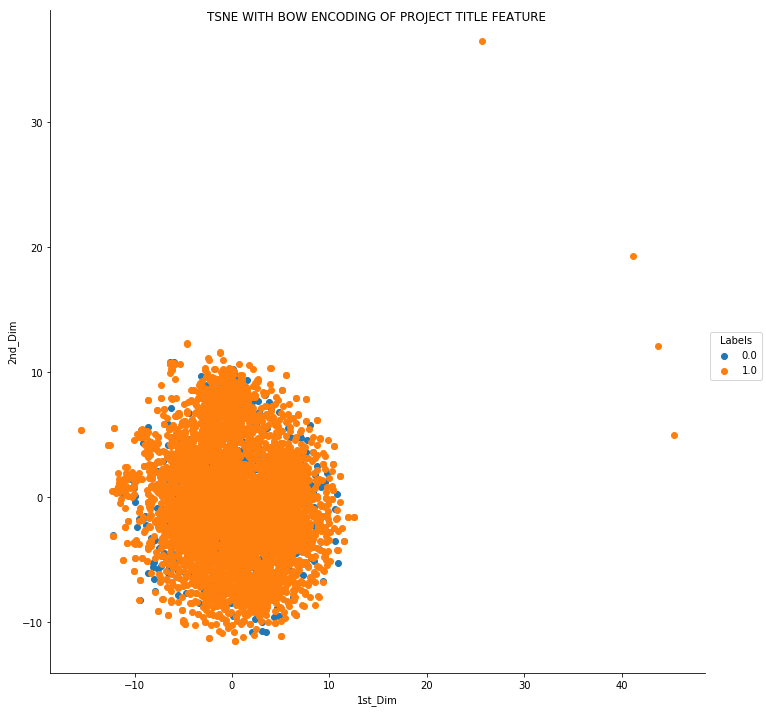

In [230]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()   

## Observations
**Lot of overlap of the data points.so we can not conclude anything from above given points.**

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [231]:

X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized))
X.shape
(109248, 5211)

(109248, 5211)

In [242]:
from sklearn.manifold import TSNE
X = X.tocsr()
X_new = X[0:5000,:]

In [243]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf = model.fit_transform(X_new)

In [244]:
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, labels_new)).T
tsne_df_tfidf = pd.DataFrame(tsne_data_tfidf, columns = ("1st_Dim","2nd_Dim","Labels"))

In [245]:
tsne_df_tfidf.shape

(5000, 3)

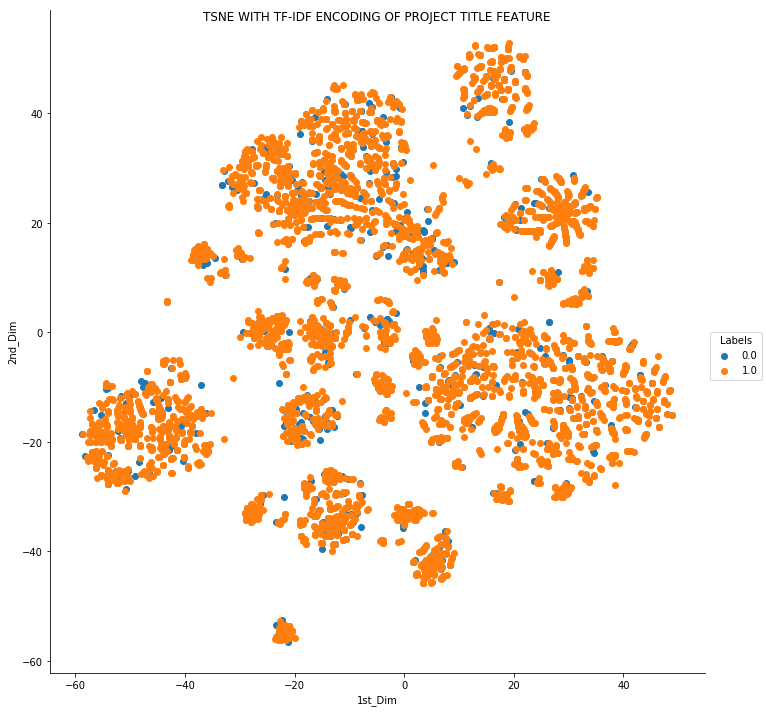

In [246]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sns.FacetGrid(tsne_df_tfidf, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH TF-IDF ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

# observations
**lots of overlapping of data points so we can't predict anything.**

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

In [249]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized))
X.shape

(109248, 102)

In [256]:
from sklearn.manifold import TSNE
X = X.tocsr()
X_new = X[0:5000,:]

In [257]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_avg_w2v = model.fit_transform(X_new)

In [258]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T, labels_new)).T
tsne_df_avg_w2v = pd.DataFrame(tsne_data_avg_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [259]:
tsne_df_avg_w2v.shape

(5000, 3)

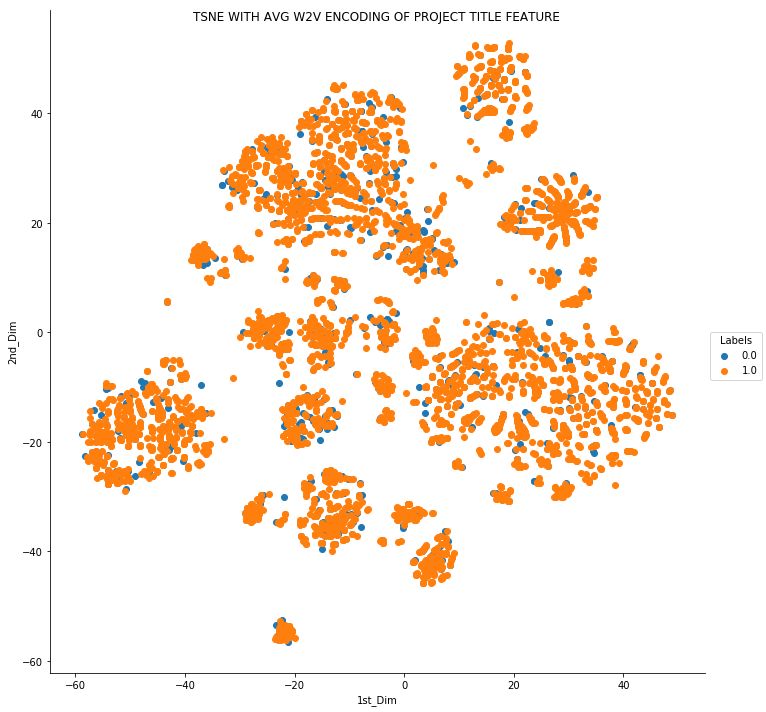

In [260]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sns.FacetGrid(tsne_df_avg_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH AVG W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()   

# Observation
We do not observe any clusters for whether the Project is accepted or not accepted. Hence we are not able to achieve the desired result using Avg- Word2vec

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [262]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized))
X.shape

(109248, 102)

In [264]:
X = X.tocsr()
X_new = X[0:5000,:]

In [265]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf_w2v = model.fit_transform(X_new)

In [266]:
tsne_data_tfidf_w2v = np.vstack((tsne_data_tfidf_w2v.T, labels_new)).T
tsne_df_tfidf_w2v = pd.DataFrame(tsne_data_tfidf_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [267]:
tsne_df_tfidf_w2v.shape

(5000, 3)

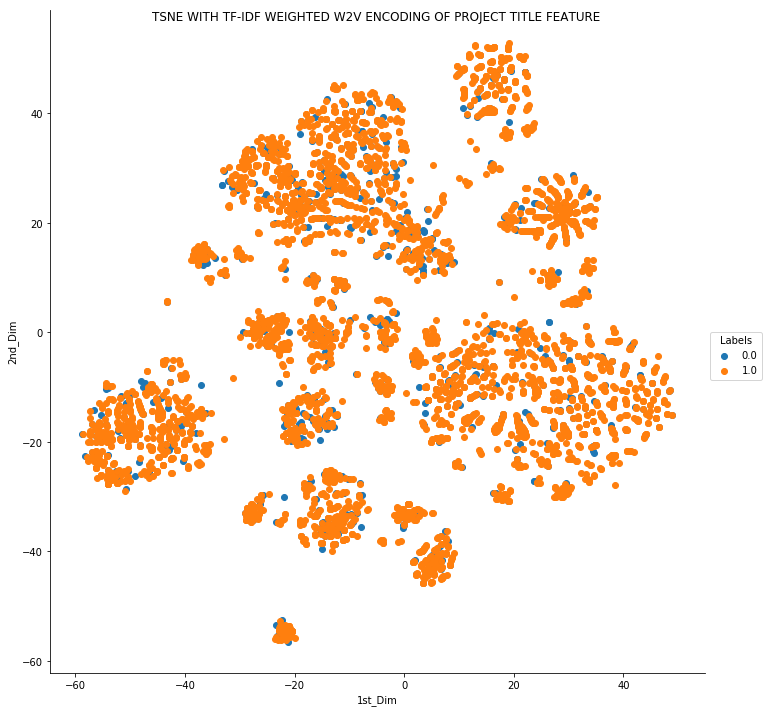

In [268]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sns.FacetGrid(tsne_df_tfidf_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH TF-IDF WEIGHTED W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()   

<h2> 2.5 Summary </h2>

**This visualisation of TSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec does not seem to yield the expected result of clustering similar data points. Hence we would have to try any other method.**

# Conclusion:
**so we can conclude that using donor's choose data set**

**1. Total no of project proposal recieved for funding is 109248 out of recieved proposal only 92706 are approved for funding and 16542 not approved for funding**

**2. school state,Teacher perfix, project subject categories,project gread categories are most usefull feature's fot predicting no of projects is approved and no of project are rejected.**